## Setting Up NIMA Retraining Pipeline Using AVA Dataset

In [14]:
import boto3
import botocore

import sys
import os

import pandas as pd
import numpy as np

import base64
import contextlib

sys.path.append('/srv/data/machine_learning')
import py_models.common.image as im

from PIL import Image
from io import BytesIO
from cStringIO import StringIO
from collections import defaultdict
# from keras.applications.resnet50 import preprocess_input

### Set up a directory for ava dataset

In [15]:
IMAGE_DIR = 'image_ava_dataset'
if IMAGE_DIR not in os.listdir(os.getcwd()):
    os.mkdir(IMAGE_DIR)

### Use AWS CLI to get all filenames

In [16]:
# Unix Command: aws s3 ls s3://airbnb-emr/image_quality/ | tr -s ' ' ',' > image_quality_idx.txt

file_names = pd.read_csv('image_quality_idx.txt', header=None, sep = ',')
file_name_list = file_names.loc[:,3]
file_name_list.head()

0     1000.jpg
1    10000.jpg
2    10002.jpg
3    10003.jpg
4    10005.jpg
Name: 3, dtype: object

### Get Ground Truth

In [17]:
# Unix Command: tr -s ' ' ',' < AVA.txt > ava_ground_truth.txt
name_lists = [
    ['idx']
    , ['image_id']
    , ['score_{}'.format(i+1) for i in range(10)]
    , ['semantic_id_{}'.format(i+1) for i in range(2)]
    , ['challenge_id']
]
column_names = [name for l in name_lists for name in l]

df_ground_truth = pd.read_csv('ava_ground_truth.txt', header=None, sep = ',')
df_ground_truth.columns = column_names
df_ground_truth = df_ground_truth.iloc[:, 1:12]
df_ground_truth.head()

,image_id,score_1,score_2,score_3,score_4,score_5,score_6,score_7,score_8,score_9,score_10
0,953619,0,1,5,17,38,36,15,6,5,1
1,953958,10,7,15,26,26,21,10,8,1,2
2,954184,0,0,4,8,41,56,10,3,4,0
3,954113,0,1,4,6,48,37,23,5,2,2
4,953980,0,3,6,15,57,39,6,1,1,1


### Define a helper function to download image from S3

In [18]:
def download_file_from_s3(FILE_NAME, BUCKET_NAME='airbnb-emr', KEY='image_quality/'):
    '''download a file from s3 using bucket_name + key'''

    s3 = boto3.resource('s3')
    image_dir = 'image_ava_dataset'
    source = KEY + FILE_NAME
    destination = os.path.join(IMAGE_DIR, FILE_NAME)

    try:
        s3.Bucket(BUCKET_NAME).download_file(source, destination)
    except botocore.exceptions.ClientError as e:
        if e.response['Error']['Code'] == "404":
            print("The object does not exist.")
        else:
            raise

# download_file_from_s3('1000.jpg')

#### Sanity Check Downloaded Image

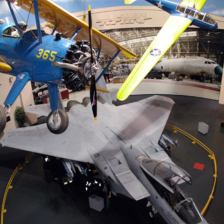

In [19]:
img_rgb = Image.open(os.path.join(IMAGE_DIR, '1000.jpg')).convert('RGB')

# print the original image
# img_rgb 

# Re-orient and Resize the image using helper function
img_rgb2 = im.reorient(img_rgb)
img_rgb2 = im.resize(img_rgb)

# print the resized image
img_rgb2

# make sure the size of the resized image is 224 x 224
# np.asarray(img_rgb, dtype=np.uint8).shape

### Resize, Encode, Save Images In a Data Frame

In [ ]:
Xt = defaultdict(list)

for i, file_name in enumerate(file_name_list[:10]):
    if i % 100 == 0:
        print "Currently processing image No.{}".format(i+1)
        
    image_id = file_name.replace('.jpg', '')
    download_file_from_s3(file_name)
    
    try:
        FILE_PATH = os.path.join(IMAGE_DIR, file_name)
        img_rgb = Image.open(FILE_PATH).convert('RGB')
        img_rgb = im.reorient(img_rgb)
        img_rgb = im.resize(img_rgb)
    except:
        "Unable to process file {}".format(file_name)
    
    with contextlib.closing(StringIO()) as output:
        img_rgb.save(output, format='jpeg')
        image_str = base64.b64encode(output.getvalue())
        
        Xt['ava_image_id'].append(image_id)
        Xt['thumbnail'].append(image_str)
        
    ground_truth = df_ground_truth.loc[df_ground_truth.image_id == int(image_id), :]
    for score in ['score_{}'.format(i+1) for i in range(10)]:
        Xt[score].append(int(ground_truth[score]))

In [21]:
Xt = pd.DataFrame.from_dict(Xt)
Xt.head()

,ava_image_id,score_1,score_10,score_2,score_3,score_4,score_5,score_6,score_7,score_8,score_9,thumbnail
0,1000,3,2,12,16,19,36,49,38,20,5,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
1,10000,6,2,12,9,33,59,33,21,8,3,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
2,10002,5,0,14,36,60,35,29,8,2,0,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
3,10003,0,3,1,4,6,19,28,15,10,2,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
4,10005,1,2,3,4,13,27,26,8,5,1,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...


#### Sanity Check Image After Decoding

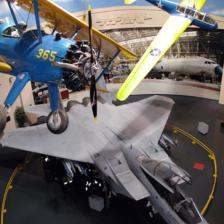

In [22]:
from IPython.display import display, Image as dImage

for thumbnail in Xt.thumbnail[:1]:
    img_decoded = base64.b64decode(thumbnail)
    display(dImage(base64.b64decode(thumbnail)))

### Upload Wrangled Data Frame to a Hive Table

In [ ]:
import logging
from collections import OrderedDict
from airflow.hooks.hive_hooks import HiveCliHook

logging.info('Begin upload dataframe to Hive')

cli = HiveCliHook('hive_silver')
cli.load_df(
    Xt
    , table='plus.dim_ava_dataset_test_mini'
    , create=True
    , recreate=True
    , field_dict=OrderedDict([
        ('ava_image_id', 'STRING')
        , ('score_1', 'STRING')
        , ('score_2', 'STRING')
        , ('score_3', 'STRING')
        , ('score_4', 'STRING')
        , ('score_5', 'STRING')
        , ('score_6', 'STRING')
        , ('score_7', 'STRING')
        , ('score_8', 'STRING')
        , ('score_9', 'STRING')
        , ('score_10', 'STRING')
        , ('thumbnail', 'STRING')
    ])
    , partition={'ds': '2018-08-19'}
    , encoding='utf8'
    , pandas_kwargs={'header': False, 'index': False}
)

logging.info('Hive table write completed')

### Sanity Check Uploaded Hive table

In [24]:
import airpy as ap

ap.presto("SELECT * FROM plus.dim_ava_dataset_test_mini;")

presto: Query: Connecting: Connected to localhost:5712.                        

[2018-08-19 21:14:28,832] {presto.py:202} INFO - SELECT *
FROM plus.dim_ava_dataset_test_mini


presto: Query: Complete after 0.67 sec on 2018-08-19.                          


,ava_image_id,score_1,score_2,score_3,score_4,score_5,score_6,score_7,score_8,score_9,score_10,thumbnail,ds
0,1000,3,2,12,16,19,36,49,38,20,5,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,2018-08-19
1,10000,6,2,12,9,33,59,33,21,8,3,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,2018-08-19
2,10002,5,0,14,36,60,35,29,8,2,0,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,2018-08-19
3,10003,0,3,1,4,6,19,28,15,10,2,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,2018-08-19
4,10005,1,2,3,4,13,27,26,8,5,1,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,2018-08-19
5,100050,0,0,3,10,38,106,81,52,27,11,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,2018-08-19
6,10006,4,1,8,19,32,51,42,20,8,2,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,2018-08-19
7,10007,3,3,0,7,12,13,20,16,10,5,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,2018-08-19
8,10008,7,0,15,47,54,38,16,6,1,1,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,2018-08-19
9,100082,0,17,2,7,25,65,79,68,50,14,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,2018-08-19


## Appendix

### Helper Function

In [ ]:
def thumbnail2vec(FILE_NAME):

    from base64 import b64decode
    from PIL import Image
    from io import BytesIO
    from keras.applications.resnet50 import preprocess_input
    FILE_PATH = os.path.join(IMAGE_DIR, FILE_NAME)

    try:
        img_rgb = Image.open(FILE_PATH).convert('RGB')
        img_rgb = im.reorient(img_rgb)
        img_rgb = im.resize(img_rgb)
        result = np.asarray(img_rgb, dtype=np.uint8)
        if np.sum(result.shape) == 224 + 224 + 3:
            result = np.expand_dims(result, axis=0)
            result = preprocess_input(result)
            return result.reshape(result.shape[1:])
        else:
            return np.zeros((224, 224, 3))
    except:
        return np.zeros((224, 224, 3))